# ASHRAE Kaggle Challenge

<a href='#1'>1. Introduction</a>

<a href='#2'>3. Combining Datasets</a>

<a href='#3'>4. Memory Limitation</a>

<a href='#4'>5. Missing Values</a>

<a href='#5'>6.EDA</a>

<a href='#6'>7. Model Training</a>

<a href='#7'>8. Model Predictions and Kaggle Submission</a>

# <a id='2'>1. Introduction</a>

**Quelle sera la consommation d'un bâtiment ?** C'est la question que pose ce challenge et donc celle à laquelle nous tenterons de répondre le plus précisément possible (la mesure de précision utilisée est la *RMSLE*, *Root Mean Square Logarithmic Error*).

Selon le ministère de la transition écologique, qui est en charge de l'établissement du calcul de diagnostique de performance écologique (*DPE*) des bâtiments et logements en France, les consommations réelles des bâtiments dépendent très directement des conditions d’usage et de la température effective de chauffage ; les consommations estimées ne sont pas une garantie contractuelle, mais elles permettent une comparaison objective de la qualité des logements et bâtiments mis en vente ou loués.

Fort heureusement nous disposons de plusieurs datasets nous renseignant sur les bâtiments étudiés :

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statistics
import pickle

In [2]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv', memory_map=True)
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv', memory_map=True)
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv', memory_map=True)
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv', memory_map=True)
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv', memory_map=True)

In [3]:
len(train), len(test)

(20216100, 41697600)

In [4]:
train = train.sample(frac = 0.0005)
test = test.sample(frac = 0.0005)

In [5]:
train.shape

(10108, 4)

In [6]:
test.shape

(20849, 4)

For a simple first model, we are going to merge the training sets to gather all covariables and make predictions on it with a linear regressor.

# <a id='2'>2. Combining Datasets</a>
We will merge everything into train and test dataframes.

We need to convert the timestamp to the right type:

In [7]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) 
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [8]:
#merge the building meta data and weather data into the train data
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test
import gc
gc.collect() #mandatory since we don't have unlimited space (16go and the databases are quite large)
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.0,NaN,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.0,8.0,20.6,4.0,12.8,0.0,1012.2,260.0,2.6
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,NaN,NaN,27.2,0.0,23.3,0.0,1014.2,0.0,0.0
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,NaN,NaN,37.2,0.0,19.4,0.0,1011.9,130.0,4.1
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,NaN,1.0,25.6,2.0,9.4,0.0,1021.9,40.0,8.2


In [9]:
del train, test

# <a id='3'>3. Memory Limitation</a>

In [10]:
# def reduce_mem_usage(df, verbose=True): #we need to drastically reduce memory usage to work with those data basis
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

#train_m = reduce_mem_usage(train_m) #this code changes the variable formats so it takes less space
#test_m = reduce_mem_usage(test_m) #source for this code : https://www.kaggle.com/alexandersylvester/ashrae-energy-predictions-with-lightgbm

# <a id='5'>5. EDA</a>

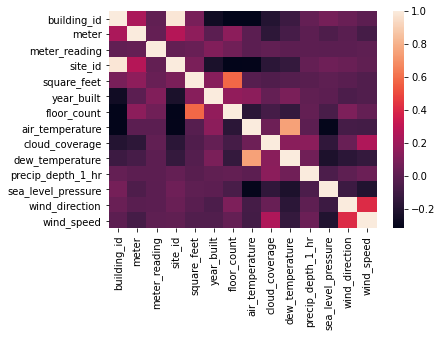

In [11]:
mat_coorr=train_m.corr()
sn.heatmap(mat_coorr)
plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

In [12]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [13]:
is_na=train_m.isnull().sum()*100/train_m.shape[0]
is_na=is_na.sort_values()
ind = np.arange(len(is_na))

In [14]:
from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn11 as palette
from bokeh.models import LinearAxis
from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect

p = figure(width = 600, height = 300)
source = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))

In [15]:
color_mapper = linear_cmap(palette=palette, low=0, high=100, field_name='y')

hist1 = p.vbar(x='x', top = 'y' , width=1,  source=source, line_color=color_mapper, fill_color = color_mapper, name = "Histogramme",alpha=0.6)

h = HoverTool( # code pour l'outil qui affiche les informations de la courbe en passant la souris dessus
    tooltips=[
        ('Variable', '@xname'),
        ('Pourcentage de NA', '$y'),#pour obtenir le nom de la courbe sur laquelle se trouve le pointeur
    ],
    renderers = [hist1]#, j]
)
p.add_tools(h)


show(p)

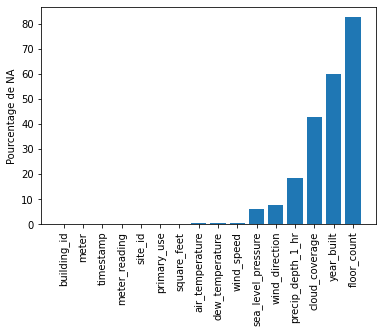

In [16]:
plt.bar(ind, is_na.values)
plt.xticks(ind,is_na.index,rotation=90)
plt.ylabel("Pourcentage de NA")
plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

In [17]:
train_m['hour_datetime'] = train_m['timestamp'].dt.hour.astype(np.int8)  
train_m['day_week'] = train_m['timestamp'].dt.dayofweek.astype(np.int8)

In [18]:
p2 = figure(width = 600, height = 300)
p3 = figure(width = 600, height = 300)#,x_axis_type = 'datetime')
# source2 = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))
# p.line(df['Date'], df.vol.mul(df.vol), line_width = 3, name= 'données réelles', color = 'purple')
# p2.line(train_m.hour_datetime, train_m.meter_reading, line_width = 2, color='black', name = 'Par heure')
p2.line(train_m.groupby('hour_datetime').hour_datetime.mean(), train_m[['hour_datetime', 'meter_reading']].groupby('hour_datetime').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par heure')

legend_list = []
for i in range(len(p2.renderers)):
        leg_tmp = LegendItem(label=p2.renderers[i].name, renderers = [p2.renderers[i]])
        legend_list.append(leg_tmp)
legend = Legend(items=legend_list, location='top_right')
p2.add_layout(legend)

show(p2)

p3.line(train_m.groupby('day_week').day_week.mean(), train_m[['day_week', 'meter_reading']].groupby('day_week').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par jour')


legend_list = []
for i in range(len(p3.renderers)):
        leg_tmp = LegendItem(label=p3.renderers[i].name, renderers = [p3.renderers[i]])
        legend_list.append(leg_tmp)
legend = Legend(items=legend_list, location='top_right')
p3.add_layout(legend)




show(p3)

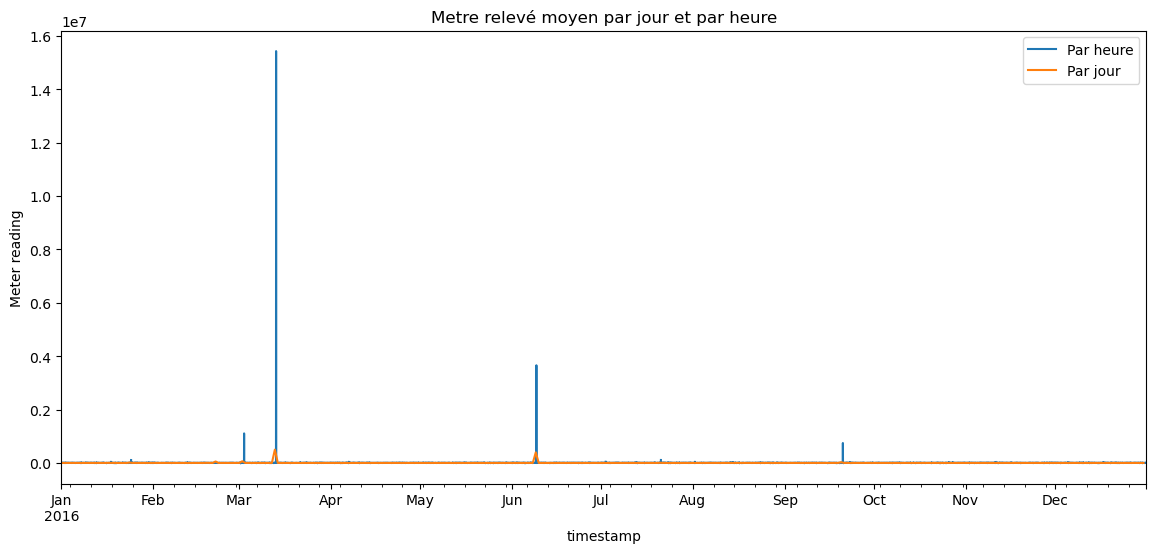

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

La forme de la distribution de la valeur cible dans le temps est plutôt étrange. On observe des pics irréguliers. Regardons de plus près.

In [20]:
import warnings
warnings.filterwarnings("ignore")

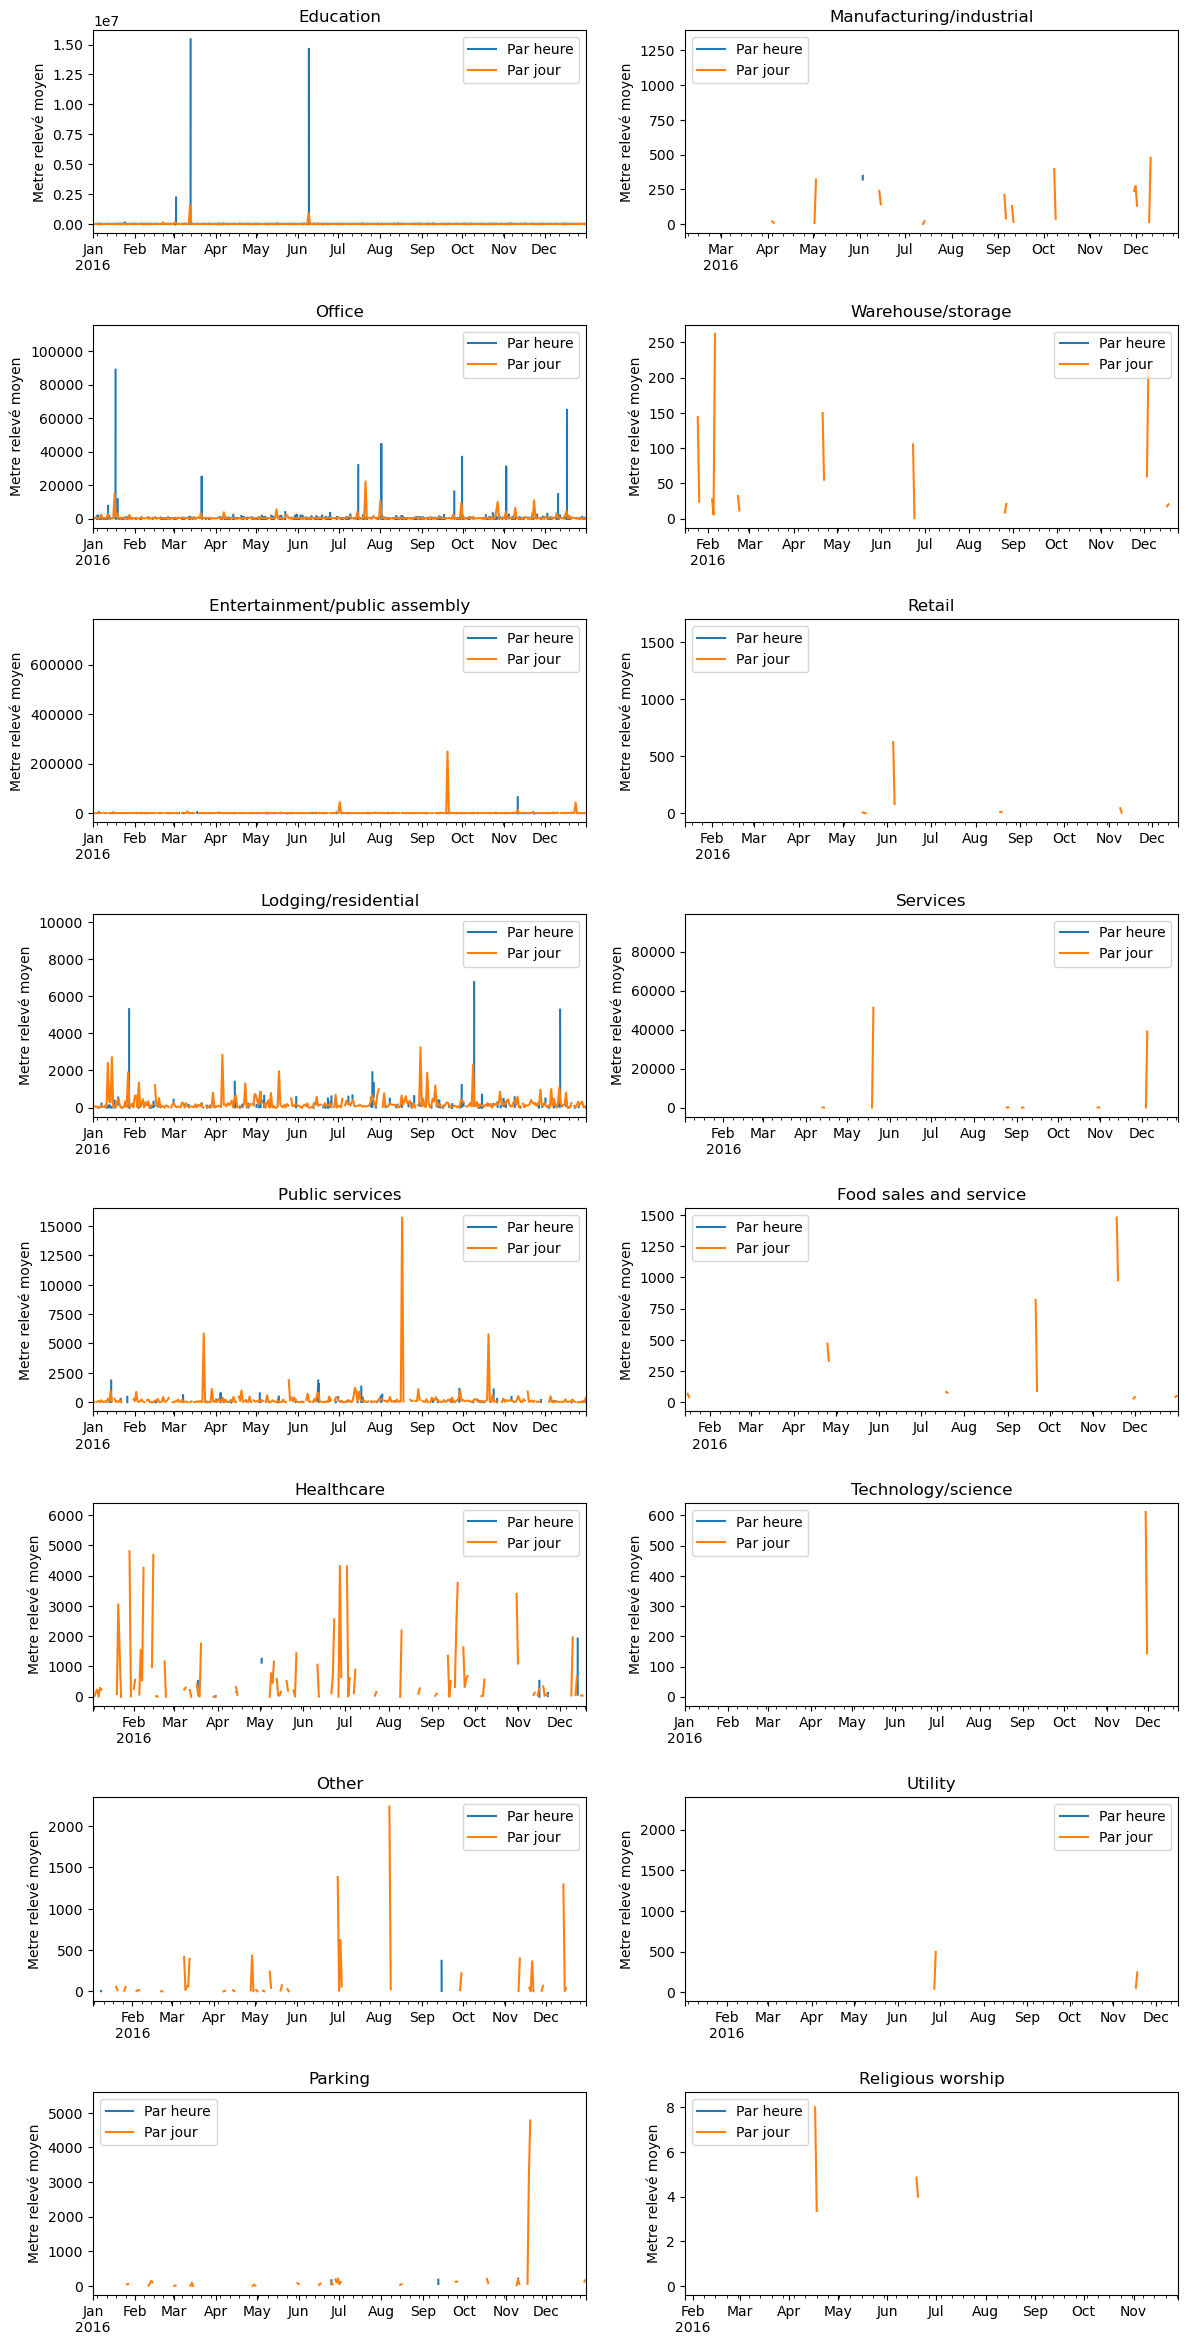

In [21]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_pu=list(train_m['primary_use'].value_counts().index);
for i in range(len(list_pu)):
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title(list_pu[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()

Notre problème se situe dans Education.

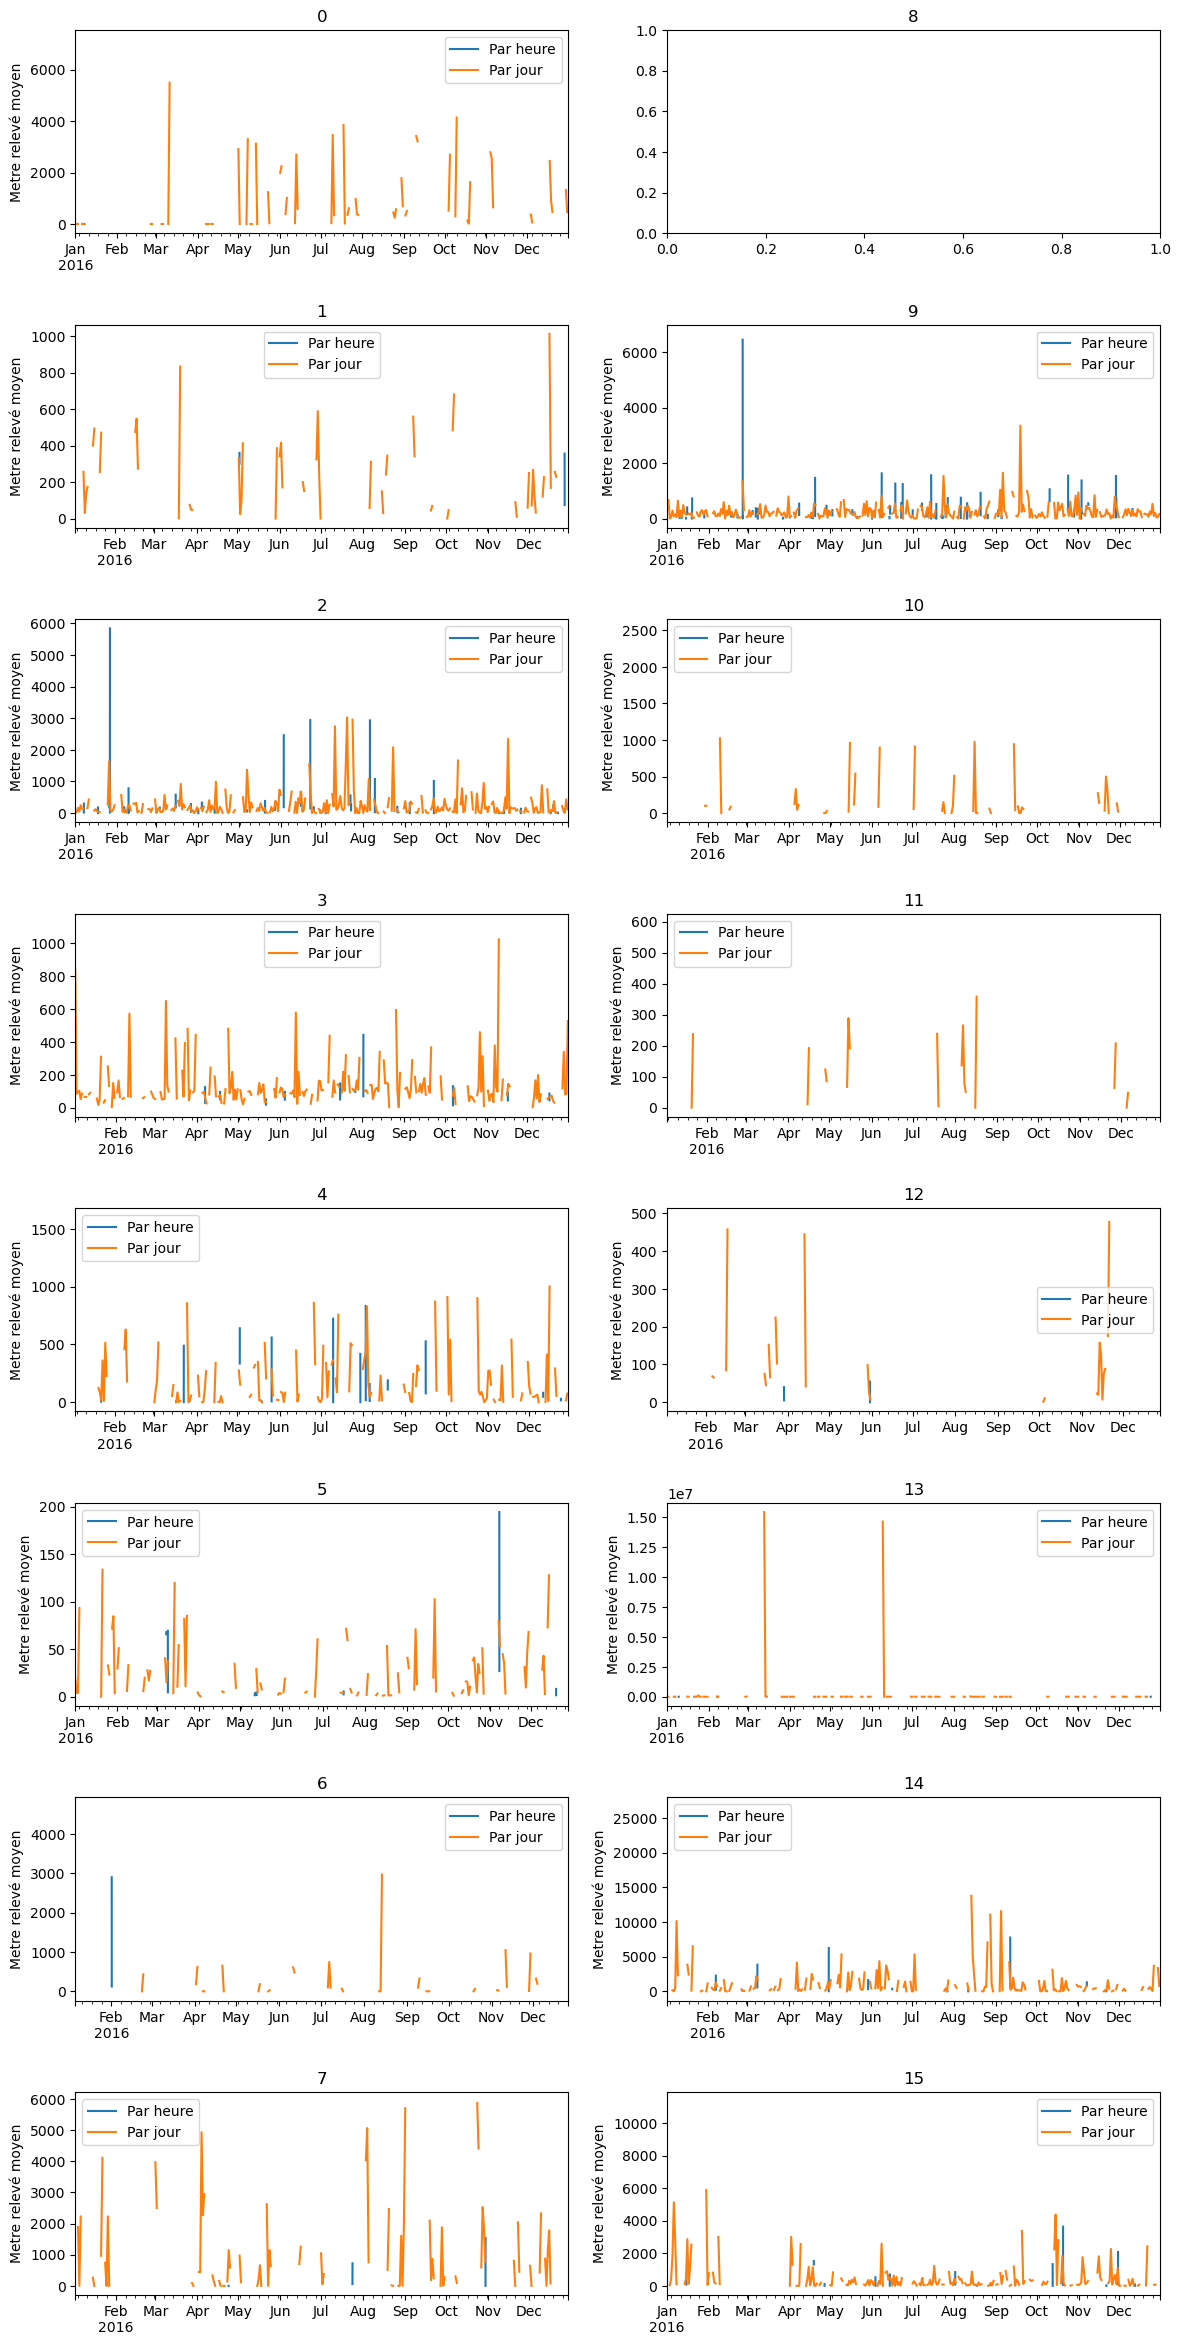

In [22]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_sid=list(train_m['site_id'].value_counts().index);
train_hist=train_m[train_m['primary_use'] == 'Education']
for i in range(len(list_sid)):
    try :
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
        axes[i%8][i//8].legend();
    except :
        pass
    axes[i%8][i//8].set_title(i);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;

Notre problème se situe dans le 13.

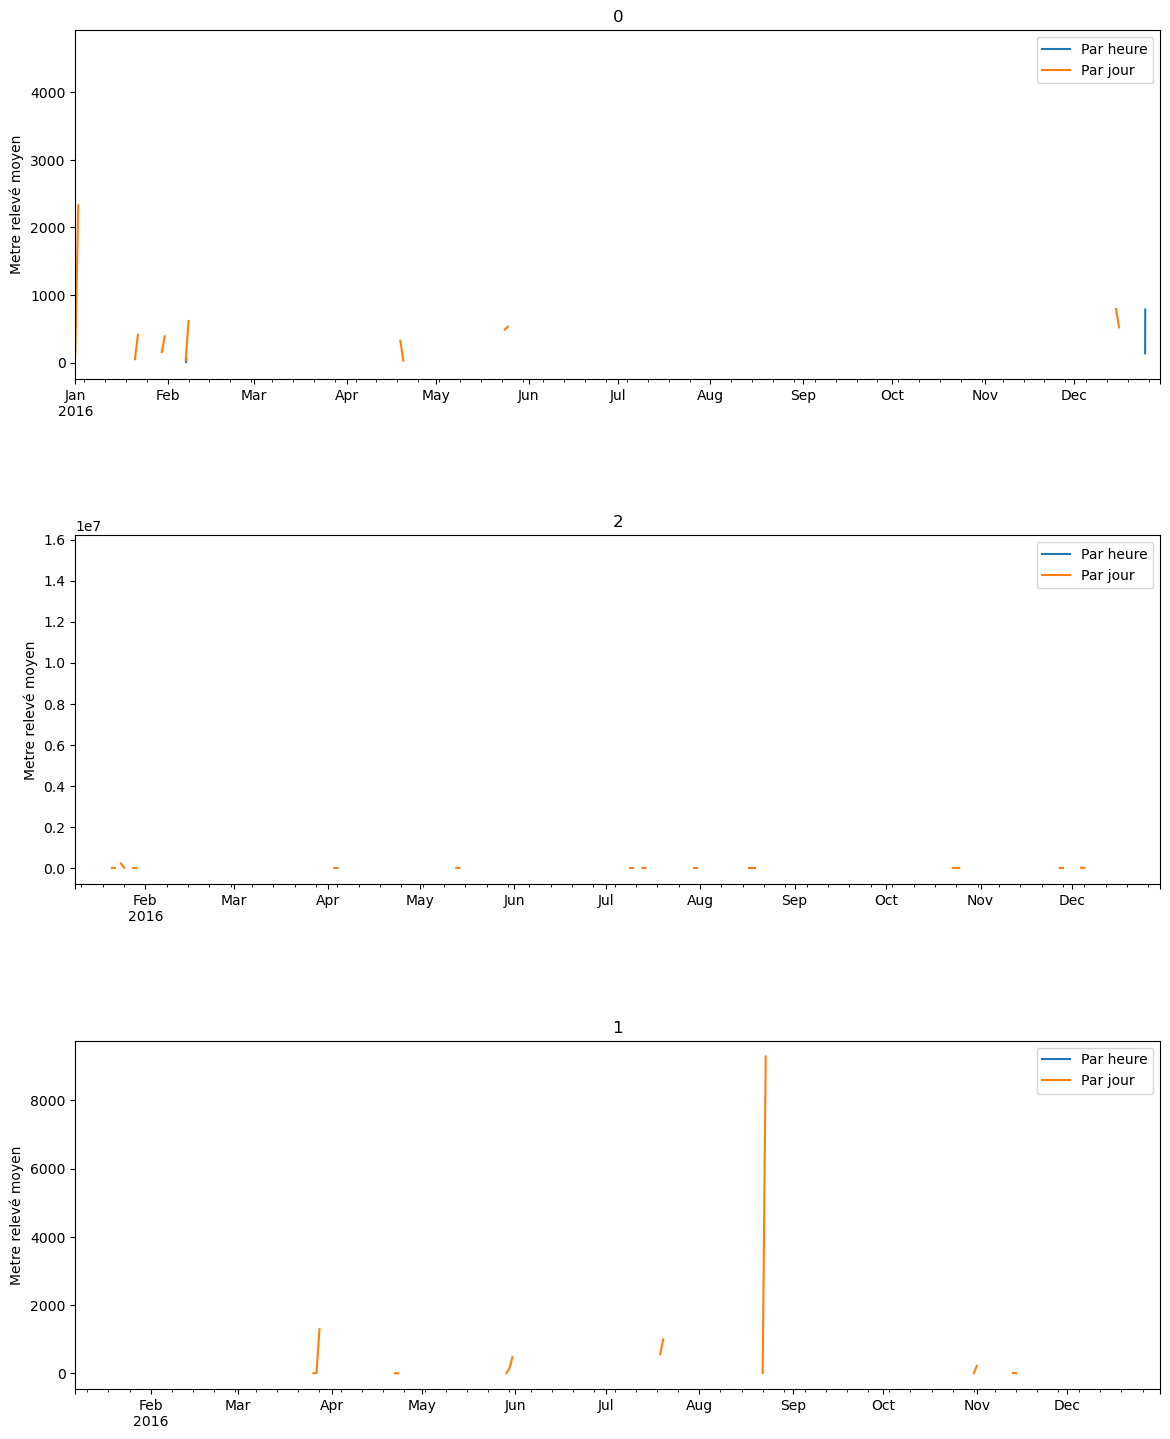

In [23]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
list_met=list(train_hist2['meter'].value_counts().index);
for i in range(len(list_met)):
    try :
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i],  label='Par jour').set_xlabel('');
        axes[i].legend();
    except TypeError:
        pass
    axes[i].set_title(list_met[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;

Le problème se situe dans le metre de type 2.

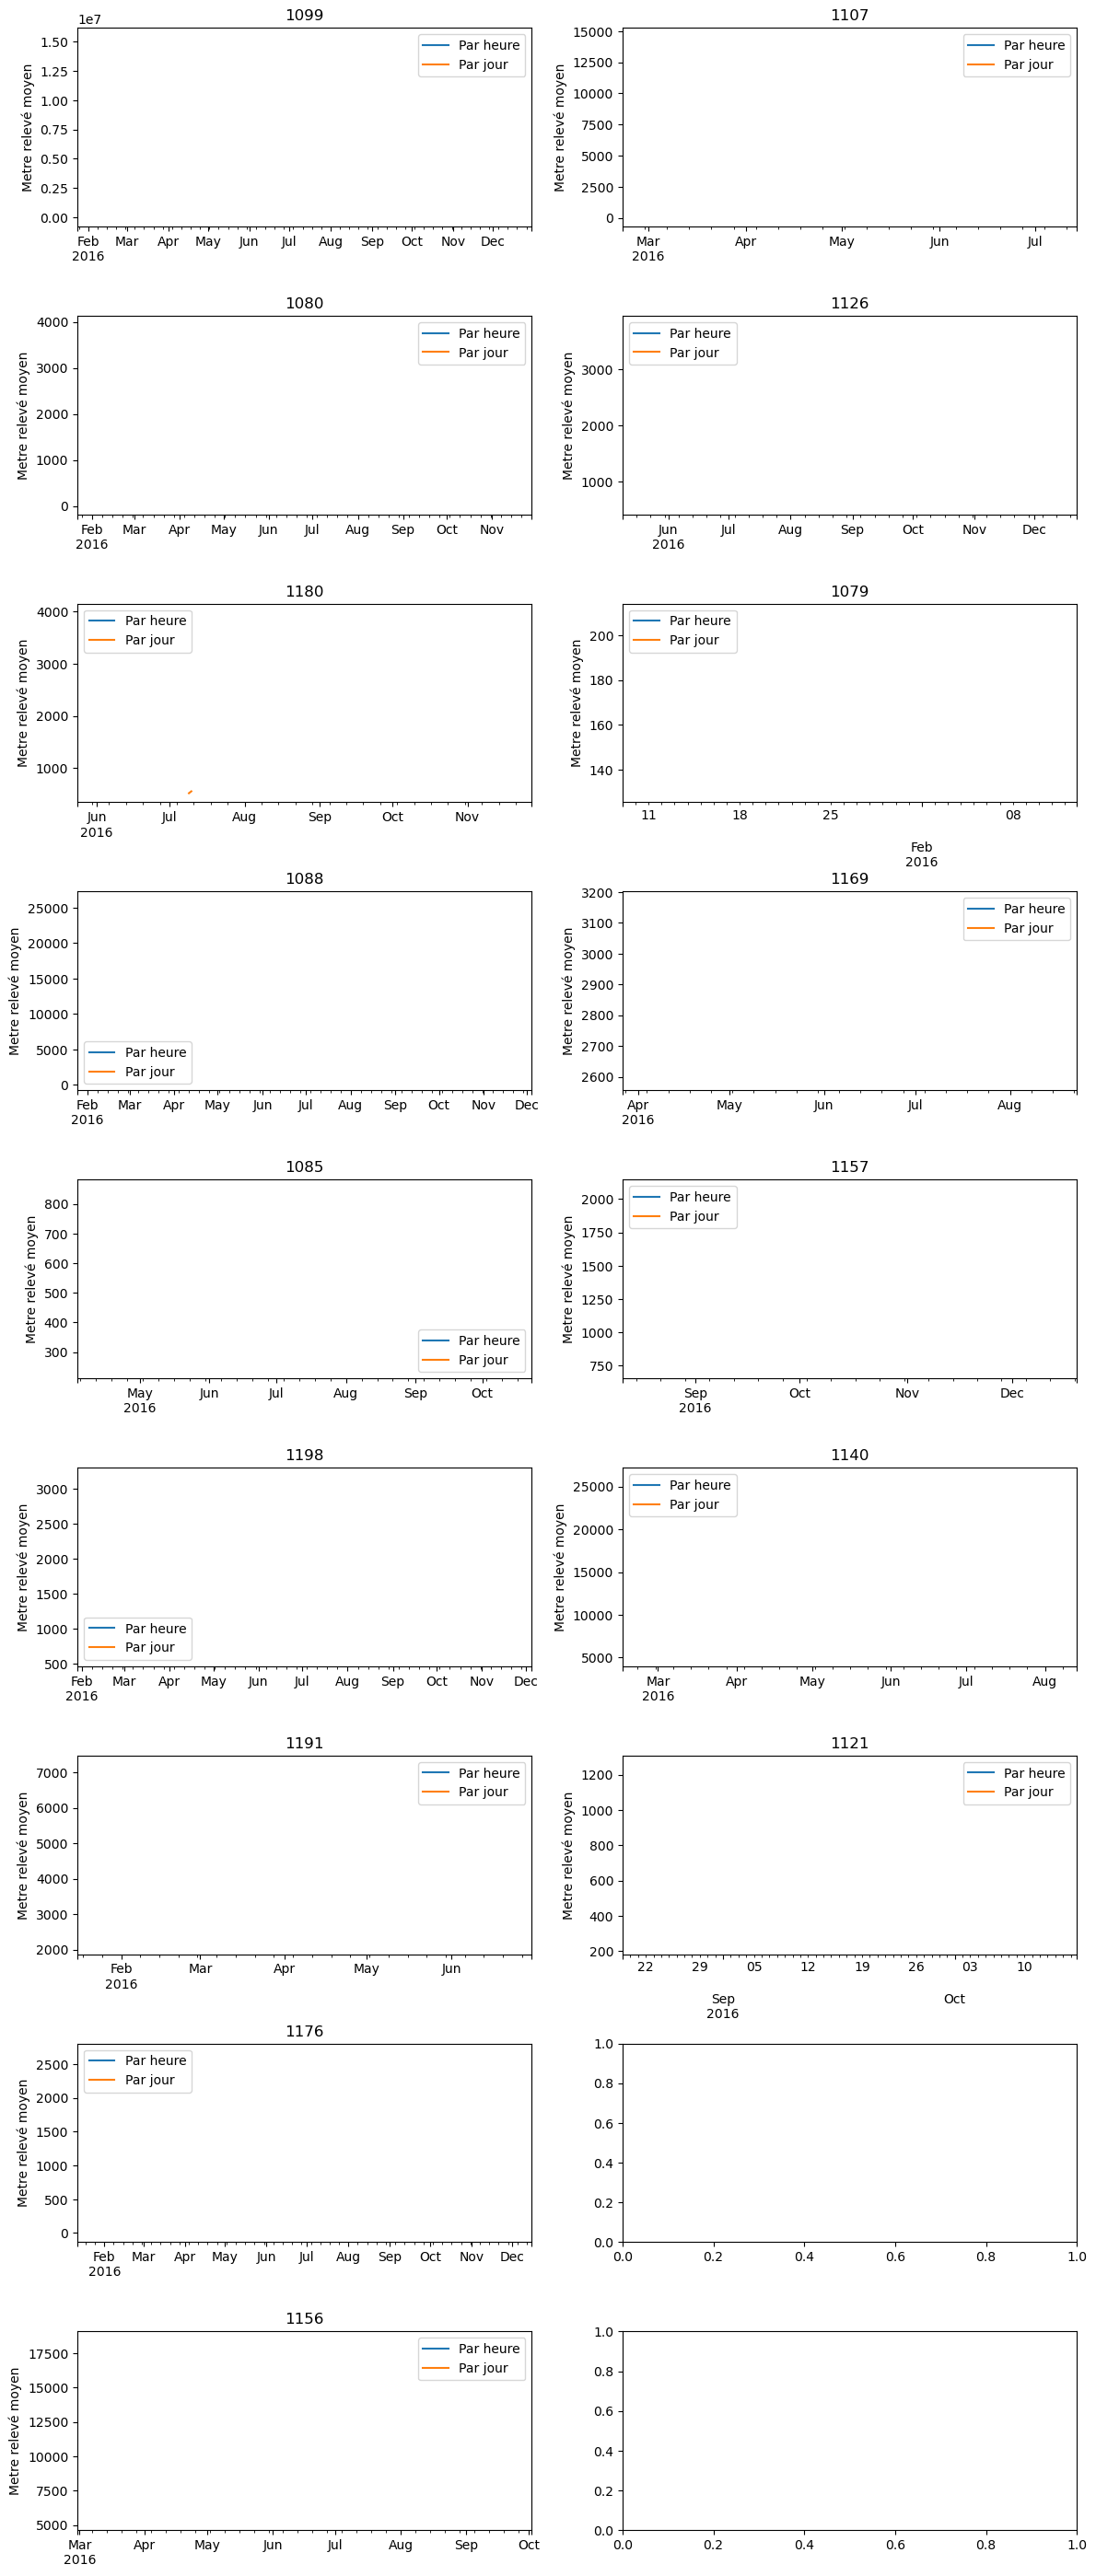

In [24]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
train_hist3=train_hist2[train_hist2['meter']==2]
list_build=list(train_hist3['building_id'].value_counts().index);
for i in range(len(list_build)):
    try :
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9],  label='Par jour').set_xlabel('');
        axes[i%9][i//9].legend();
    except TypeError:
        pass
    axes[i%9][i//9].set_title(list_build[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;
del train_hist3;

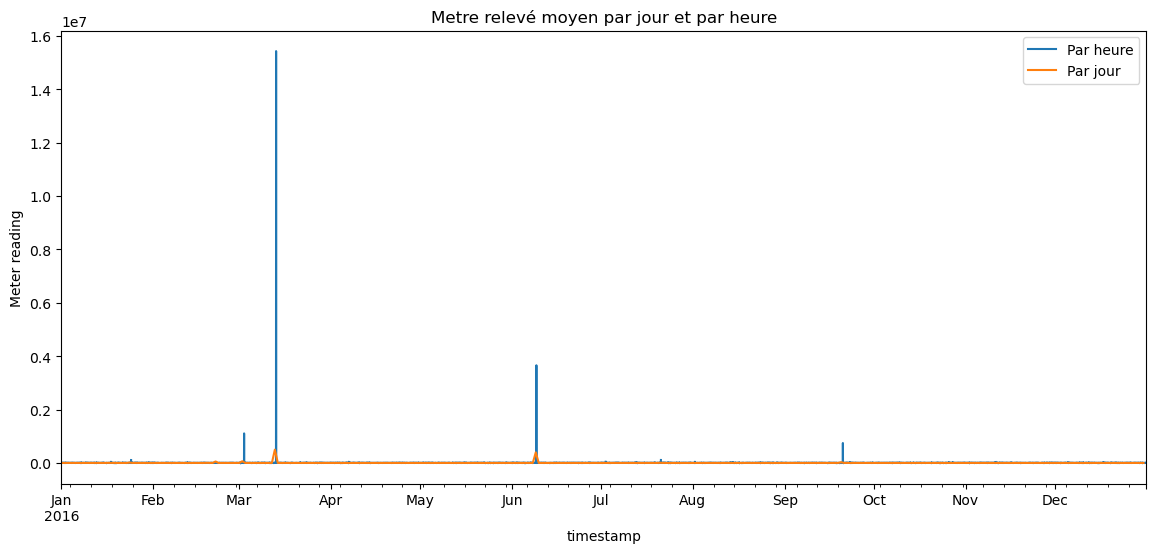

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

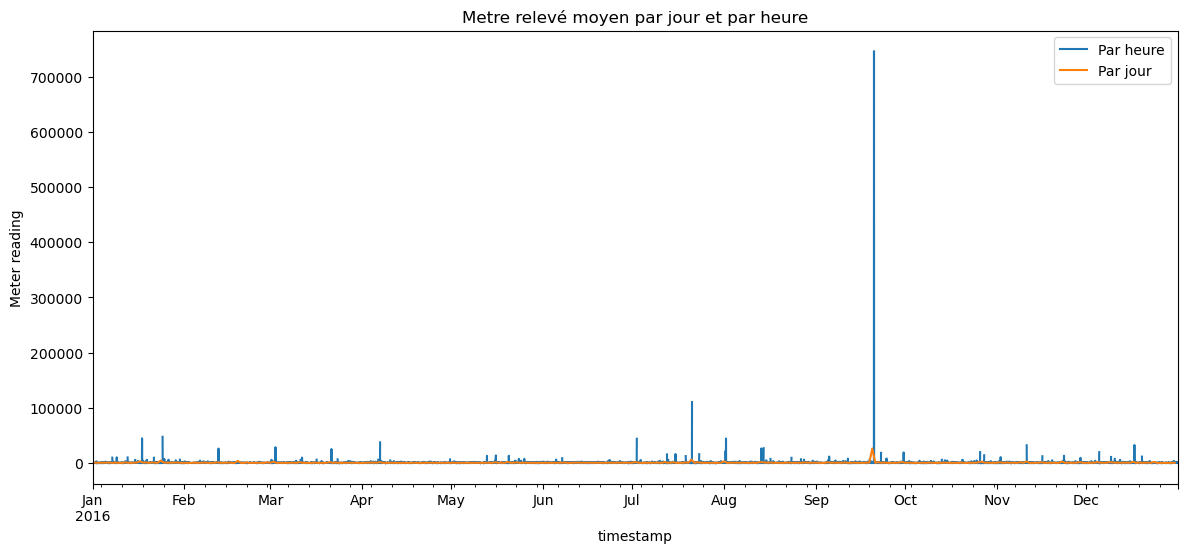

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
new_train=train_m[train_m['building_id'] != 1099]
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

In [27]:
new_test=test_m
new_test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,18693113,827,0,2017-06-02 12:00:00,8,Office,5839,NaN,1.0,23.3,8.0,22.8,-1.0,1017.5,80.0,2.1
1,4002775,239,0,2017-04-05 05:00:00,2,Lodging/residential,106440,1963.0,NaN,22.8,0.0,-9.4,0.0,1014.3,320.0,2.1
2,36986066,1223,1,2018-12-01 07:00:00,14,Office,52141,NaN,NaN,2.8,0.0,-0.6,0.0,1019.4,0.0,0.0
3,14351583,638,0,2018-06-06 20:00:00,4,Education,7900,1923.0,4.0,16.7,NaN,11.1,0.0,1013.8,250.0,7.2
4,7395428,279,1,2018-08-07 08:00:00,2,Education,49384,1967.0,NaN,36.7,2.0,10.6,0.0,1004.8,160.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,17099338,765,0,2018-01-31 09:00:00,6,Entertainment/public assembly,58562,NaN,NaN,-6.1,0.0,-13.3,0.0,1027.3,0.0,0.0
20845,20743897,922,1,2017-05-28 06:00:00,9,Education,147205,NaN,NaN,25.6,2.0,22.8,0.0,1009.5,NaN,2.1
20846,16054188,742,0,2018-08-10 01:00:00,5,Entertainment/public assembly,31829,1976.0,2.0,13.0,NaN,11.0,NaN,NaN,250.0,3.6
20847,40179553,1437,2,2018-05-23 18:00:00,15,Education,111518,1968.0,NaN,22.2,2.0,13.3,NaN,1017.4,290.0,5.1


In [28]:
del train_m
del test_m

Remplacement NA

In [29]:
for i in list_pu:
    print(i)
    print(new_train[new_train['primary_use']==i].isnull().sum()*100/new_train[new_train['primary_use']==i].shape[0])
    print("")

Education
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            49.264345
floor_count           75.919568
air_temperature        0.441393
cloud_coverage        43.379107
dew_temperature        0.465915
precip_depth_1_hr     25.282001
sea_level_pressure     7.896027
wind_direction         8.582639
wind_speed             0.711133
hour_datetime          0.000000
day_week               0.000000
dtype: float64

Office
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            76.232785
floor_count           92.758774
air_temperature        0.488672
cloud_coverage        42.825411
dew_temperature        0.488672
precip_

`Services`, `Food sales and service`, `Religious worship` n'ont aucune donnée pour la variable `floor_count`. Nous allons d'abord combler ce qu'il manque dans les autres catégories par la moyenne. 

In [30]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.964325
floor_count           82.519076
air_temperature        0.465762
cloud_coverage        42.879794
dew_temperature        0.475671
precip_depth_1_hr     18.660192
sea_level_pressure     6.263007
wind_direction         7.511644
wind_speed             0.673868
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [31]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.446496
floor_count           82.867284
air_temperature        0.455657
cloud_coverage        46.918317
dew_temperature        0.556382
precip_depth_1_hr     18.461317
sea_level_pressure     5.995491
wind_direction         7.194590
wind_speed             0.681088
dtype: float64

In [32]:
import statistics
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)        


In [33]:
for i in range(len(list_pu)):
    if (list_pu[i]!="Services") & (list_pu[i]!="Food sales and service") & (list_pu[i]!="Religious worship") :
        new_train.loc[new_train.primary_use==list_pu[i],['floor_count']]=new_train[new_train['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['floor_count']]=new_test[new_test['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.0,2.220859,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.0,8.000000,20.6,4.0,12.8,0.0,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,NaN,5.184318,27.2,0.0,23.3,0.0,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,NaN,5.184318,37.2,0.0,19.4,0.0,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,NaN,1.000000,25.6,2.0,9.4,0.0,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.0,5.184318,8.9,2.0,-4.4,0.0,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.0,6.134615,-8.9,2.0,-15.0,NaN,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.0,5.184318,32.2,2.0,13.9,0.0,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,NaN,2.025830,2.8,0.0,-1.7,0.0,1016.7,320.0,1.5,12,3


In [34]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [35]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['floor_count']]=new_train[new_train['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['floor_count']]=new_test[new_test['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.0,2.220859,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.0,8.000000,20.6,4.0,12.8,0.0,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,NaN,5.184318,27.2,0.0,23.3,0.0,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,NaN,5.184318,37.2,0.0,19.4,0.0,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,NaN,1.000000,25.6,2.0,9.4,0.0,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.0,5.184318,8.9,2.0,-4.4,0.0,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.0,6.134615,-8.9,2.0,-15.0,NaN,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.0,5.184318,32.2,2.0,13.9,0.0,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,NaN,2.025830,2.8,0.0,-1.7,0.0,1016.7,320.0,1.5,12,3


In [36]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.964325
floor_count            0.000000
air_temperature        0.465762
cloud_coverage        42.879794
dew_temperature        0.475671
precip_depth_1_hr     18.660192
sea_level_pressure     6.263007
wind_direction         7.511644
wind_speed             0.673868
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [37]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.446496
floor_count            0.000000
air_temperature        0.455657
cloud_coverage        46.918317
dew_temperature        0.556382
precip_depth_1_hr     18.461317
sea_level_pressure     5.995491
wind_direction         7.194590
wind_speed             0.681088
dtype: float64

C'est bon pour `floor_count`, au tour de `year_built`

In [38]:
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)

In [39]:
for i in range(len(list_pu)):
    if list_pu[i]!="Services":
        new_train.loc[new_train.primary_use==list_pu[i],['year_built']]=new_train[new_train['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['year_built']]=new_test[new_test['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.000000,2.220859,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.000000,8.000000,20.6,4.0,12.8,0.0,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,1963.844853,5.184318,27.2,0.0,23.3,0.0,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,1963.844853,5.184318,37.2,0.0,19.4,0.0,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,1970.979215,1.000000,25.6,2.0,9.4,0.0,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.000000,5.184318,8.9,2.0,-4.4,0.0,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.000000,6.134615,-8.9,2.0,-15.0,NaN,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.000000,5.184318,32.2,2.0,13.9,0.0,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,1970.979215,2.025830,2.8,0.0,-1.7,0.0,1016.7,320.0,1.5,12,3


In [40]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.554950
floor_count            0.000000
air_temperature        0.465762
cloud_coverage        42.879794
dew_temperature        0.475671
precip_depth_1_hr     18.660192
sea_level_pressure     6.263007
wind_direction         7.511644
wind_speed             0.673868
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [41]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.460454
floor_count            0.000000
air_temperature        0.455657
cloud_coverage        46.918317
dew_temperature        0.556382
precip_depth_1_hr     18.461317
sea_level_pressure     5.995491
wind_direction         7.194590
wind_speed             0.681088
dtype: float64

In [42]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [43]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['year_built']]=new_train[new_train['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['year_built']]=new_test[new_test['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.000000,2.220859,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.000000,8.000000,20.6,4.0,12.8,0.0,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,1963.844853,5.184318,27.2,0.0,23.3,0.0,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,1963.844853,5.184318,37.2,0.0,19.4,0.0,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,1970.979215,1.000000,25.6,2.0,9.4,0.0,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.000000,5.184318,8.9,2.0,-4.4,0.0,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.000000,6.134615,-8.9,2.0,-15.0,NaN,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.000000,5.184318,32.2,2.0,13.9,0.0,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,1970.979215,2.025830,2.8,0.0,-1.7,0.0,1016.7,320.0,1.5,12,3


In [44]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.465762
cloud_coverage        42.879794
dew_temperature        0.475671
precip_depth_1_hr     18.660192
sea_level_pressure     6.263007
wind_direction         7.511644
wind_speed             0.673868
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [45]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.455657
cloud_coverage        46.918317
dew_temperature        0.556382
precip_depth_1_hr     18.461317
sea_level_pressure     5.995491
wind_direction         7.194590
wind_speed             0.681088
dtype: float64

Pour les infos météo, on se base seulement selon le site. Se baser sur `primary_use` n'aurait pas de sens pour ce type de donnée.

In [46]:
for i in list_sid:
    print(i)
    print(new_train[new_train['site_id']==i].isnull().sum()*100/new_train[new_train['site_id']==i].shape[0])
    print("")

13
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.000000
cloud_coverage        48.660714
dew_temperature        0.000000
precip_depth_1_hr      0.223214
sea_level_pressure     1.562500
wind_direction         2.827381
wind_speed             0.000000
hour_datetime          0.000000
day_week               0.000000
dtype: float64

9
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.075873
cloud_coverage        38.012140
dew_temperature        0.075873
precip_depth_1_hr  

In [47]:
#cloud coverage
#site id 7, 11 n'ont aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 7) & (list_sid[i] != 11):
        new_train.loc[new_train.site_id==list_sid[i],['cloud_coverage']]=new_train[new_train['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['cloud_coverage']]=new_test[new_test['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.000000,2.220859,28.9,2.0,-1.1,0.0,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.000000,8.000000,20.6,4.0,12.8,0.0,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,1963.844853,5.184318,27.2,0.0,23.3,0.0,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,1963.844853,5.184318,37.2,0.0,19.4,0.0,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,1970.979215,1.000000,25.6,2.0,9.4,0.0,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.000000,5.184318,8.9,2.0,-4.4,0.0,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.000000,6.134615,-8.9,2.0,-15.0,NaN,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.000000,5.184318,32.2,2.0,13.9,0.0,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,1970.979215,2.025830,2.8,0.0,-1.7,0.0,1016.7,320.0,1.5,12,3


In [48]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 2% de cloud_coverage inconnu

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.465762
cloud_coverage         2.507185
dew_temperature        0.475671
precip_depth_1_hr     18.660192
sea_level_pressure     6.263007
wind_direction         7.511644
wind_speed             0.673868
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [49]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.455657
cloud_coverage         2.263898
dew_temperature        0.556382
precip_depth_1_hr     18.461317
sea_level_pressure     5.995491
wind_direction         7.194590
wind_speed             0.681088
dtype: float64

In [50]:
#precip_depth_1_hr
#12, 5, 1 n'ont pas de donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)
        
for i in range(len(list_sid)):
    if (list_sid[i] != 12) & (list_sid[i] != 5) & (list_sid[i] != 1):
        new_train.loc[new_train.site_id==list_sid[i],['precip_depth_1_hr']]=new_train[new_train['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['precip_depth_1_hr']]=new_test[new_test['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.000000,2.220859,28.9,2.0,-1.1,0.000000,1010.9,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.000000,8.000000,20.6,4.0,12.8,0.000000,1012.2,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,1963.844853,5.184318,27.2,0.0,23.3,0.000000,1014.2,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,1963.844853,5.184318,37.2,0.0,19.4,0.000000,1011.9,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,1970.979215,1.000000,25.6,2.0,9.4,0.000000,1021.9,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.000000,5.184318,8.9,2.0,-4.4,0.000000,1025.2,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.000000,6.134615,-8.9,2.0,-15.0,4.772455,NaN,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.000000,5.184318,32.2,2.0,13.9,0.000000,1010.3,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,1970.979215,2.025830,2.8,0.0,-1.7,0.000000,1016.7,320.0,1.5,12,3


In [51]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 8% d'inconnu pour precip_depth_1_hr

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.465762
cloud_coverage        2.507185
dew_temperature       0.475671
precip_depth_1_hr     8.135963
sea_level_pressure    6.263007
wind_direction        7.511644
wind_speed            0.673868
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [52]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.455657
cloud_coverage        2.263898
dew_temperature       0.556382
precip_depth_1_hr     7.674229
sea_level_pressure    5.995491
wind_direction        7.194590
wind_speed            0.681088
dtype: float64

In [53]:
#sea_lever_pressure
#le site 5 n'a aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if list_sid[i] != 5:
        new_train.loc[new_train.site_id==list_sid[i],['sea_level_pressure']]=new_train[new_train['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['sea_level_pressure']]=new_test[new_test['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,206,3,2016-02-16 21:00:00,0.0000,2,Public services,345837,1966.000000,2.220859,28.9,2.0,-1.1,0.000000,1010.900000,0.0,0.0,21,1
1,569,0,2016-02-16 21:00:00,420.0000,4,Education,86091,1964.000000,8.000000,20.6,4.0,12.8,0.000000,1012.200000,260.0,2.6,21,1
2,890,0,2016-09-18 07:00:00,380.0000,9,Education,202937,1963.844853,5.184318,27.2,0.0,23.3,0.000000,1014.200000,0.0,0.0,7,6
3,900,1,2016-07-23 21:00:00,691.8350,9,Education,111623,1963.844853,5.184318,37.2,0.0,19.4,0.000000,1011.900000,130.0,4.1,21,5
4,846,0,2016-04-18 21:00:00,0.4167,8,Entertainment/public assembly,481,1970.979215,1.000000,25.6,2.0,9.4,0.000000,1021.900000,40.0,8.2,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,Education,4314,1907.000000,5.184318,8.9,2.0,-4.4,0.000000,1025.200000,0.0,0.0,16,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,Lodging/residential,61439,1903.000000,6.134615,-8.9,2.0,-15.0,4.772455,1017.032718,200.0,2.6,3,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,Education,12761,1909.000000,5.184318,32.2,2.0,13.9,0.000000,1010.300000,110.0,3.1,15,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,Entertainment/public assembly,166489,1970.979215,2.025830,2.8,0.0,-1.7,0.000000,1016.700000,320.0,1.5,12,3


In [54]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 3.8% d'inconnu pour sea_level_pressure

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.465762
cloud_coverage        2.507185
dew_temperature       0.475671
precip_depth_1_hr     8.135963
sea_level_pressure    4.023387
wind_direction        7.511644
wind_speed            0.673868
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [55]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.455657
cloud_coverage        2.263898
dew_temperature       0.556382
precip_depth_1_hr     7.674229
sea_level_pressure    3.750779
wind_direction        7.194590
wind_speed            0.681088
dtype: float64

In [56]:
#air_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['air_temperature']]=new_train[new_train['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['air_temperature']]=new_test[new_test['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean_test[i])
new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.507185
dew_temperature       0.475671
precip_depth_1_hr     8.135963
sea_level_pressure    4.023387
wind_direction        7.511644
wind_speed            0.673868
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [57]:
#dew_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['dew_temperature']]=new_train[new_train['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['dew_temperature']]=new_test[new_test['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.507185
dew_temperature       0.000000
precip_depth_1_hr     8.135963
sea_level_pressure    4.023387
wind_direction        7.511644
wind_speed            0.673868
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [58]:
#wind_direction
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_direction']]=new_train[new_train['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_direction']]=new_test[new_test['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.507185
dew_temperature       0.000000
precip_depth_1_hr     8.135963
sea_level_pressure    4.023387
wind_direction        0.000000
wind_speed            0.673868
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [59]:
#wind_speed
list_sid_mean=[]
list_sid_mean_test=[]

for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_speed']]=new_train[new_train['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_speed']]=new_test[new_test['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.507185
dew_temperature       0.000000
precip_depth_1_hr     8.135963
sea_level_pressure    4.023387
wind_direction        0.000000
wind_speed            0.000000
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [60]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.263898
dew_temperature       0.000000
precip_depth_1_hr     7.674229
sea_level_pressure    3.750779
wind_direction        0.000000
wind_speed            0.000000
dtype: float64

Pour bien terminer le travail, et finir de remplir les derniers NA, il faudrait comparer les données météo pour retrouver les villes des différents sites et récupérer les données. On pourrait même remplacer les données moyennes ajoutées aux données météo par les valeurs réelles trouvées.

In [61]:
#FE
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

new_train['date'] = new_train.timestamp.dt.date
new_train ['heure'] = new_train.timestamp.dt.hour
new_train ['mois'] = new_train.timestamp.dt.month
new_train ['joursemaine'] = new_train.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_train.timestamp.min(), end=new_train.timestamp.max())
#new_train['EstVac'] = new_train['timestamp'].isin(vac)

new_test['date'] = new_test.timestamp.dt.date
new_test['heure'] = new_test.timestamp.dt.hour
new_test['mois'] = new_test.timestamp.dt.month
new_test['joursemaine'] = new_test.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_test.timestamp.min(), end=new_test.timestamp.max())
#new_test['EstVac'] = new_test['timestamp'].isin(vac)

In [62]:
new_train.primary_use = new_train.primary_use.astype('category')
new_test.primary_use = new_test.primary_use.astype('category')

In [63]:
train_df = new_train.dropna(axis='columns')


In [64]:
test_df=new_test.dropna(axis='columns')

In [65]:
test_df.shape

(20849, 17)

# <a id='6'>6. Model Training</a>

In [66]:
%%time
from sklearn.model_selection import GridSearchCV #, train_test_split,TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

y_train = new_train['meter_reading']

# my_tree = DecisionTreeRegressor()

# MSE = make_scorer(mean_squared_error)

Wall time: 250 ms


In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_df['primary_use'])
train_df['primary_use']=le.transform(train_df['primary_use'])


In [68]:
test_df['primary_use']=le.transform(test_df['primary_use'])

In [69]:
train_df['date']=pd.to_numeric(pd.to_datetime(train_df['date']))

In [70]:
test_df['date']=pd.to_numeric(pd.to_datetime(test_df['date']))

In [71]:
train_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,wind_direction,wind_speed,hour_datetime,day_week,date,heure,mois,joursemaine
0,206,3,2016-02-16 21:00:00,0.0000,2,9,345837,1966.000000,2.220859,28.9,-1.1,0.0,0.0,21,1,1455580800000000000,21,2,1
1,569,0,2016-02-16 21:00:00,420.0000,4,0,86091,1964.000000,8.000000,20.6,12.8,260.0,2.6,21,1,1455580800000000000,21,2,1
2,890,0,2016-09-18 07:00:00,380.0000,9,0,202937,1963.844853,5.184318,27.2,23.3,0.0,0.0,7,6,1474156800000000000,7,9,6
3,900,1,2016-07-23 21:00:00,691.8350,9,0,111623,1963.844853,5.184318,37.2,19.4,130.0,4.1,21,5,1469232000000000000,21,7,5
4,846,0,2016-04-18 21:00:00,0.4167,8,1,481,1970.979215,1.000000,25.6,9.4,40.0,8.2,21,0,1460937600000000000,21,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,252,1,2016-12-19 16:00:00,0.0000,2,0,4314,1907.000000,5.184318,8.9,-4.4,0.0,0.0,16,0,1482105600000000000,16,12,0
10104,1358,2,2016-01-12 03:00:00,990.2610,15,4,61439,1903.000000,6.134615,-8.9,-15.0,200.0,2.6,3,1,1452556800000000000,3,1,1
10105,277,0,2016-08-31 15:00:00,32.0700,2,0,12761,1909.000000,5.184318,32.2,13.9,110.0,3.1,15,2,1472601600000000000,15,8,2
10106,1322,0,2016-11-10 12:00:00,143.7120,14,1,166489,1970.979215,2.025830,2.8,-1.7,320.0,1.5,12,3,1478736000000000000,12,11,3


In [72]:
# param_grid = {'splitter' : ['best', 'random'],'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson']}
# model = GridSearchCV(my_tree, param_grid, scoring=MSE)

In [73]:
train_df = train_df.drop('timestamp', axis = 1)

In [74]:
test_df = test_df.drop('timestamp', axis = 1)

In [75]:
# predicted = model.predict(test_df)

# print('Best Parameters found for MSE : ',model.best_params_)
# print('Train Score : ',model.score(train_m.drop('meter_reading') , y_train))


from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from math import sqrt

X = train_df

y = y_train

reg = tree.DecisionTreeRegressor(max_leaf_nodes=50000)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression de train",sqrt(mean_squared_error(y, y_train_predict_tree)))

La RMSE de l'arbre de régression de train 7.120544914251905e-16


In [76]:
print("La RMSLE de l'arbre de régression de train",sqrt(mean_squared_log_error(y, y_train_predict_tree)))

La RMSLE de l'arbre de régression de train 2.2132481993506998e-17


Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

In [77]:
#obtention des prédictions et du fichier à évaluer 
X_test = test_df
y_test_predict_tree=reg.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features is 18 and input n_features is 16 

In [ ]:
my_submission = pd.DataFrame({'row_id': test_df.index, 'meter_reading': y_test_predict_tree})
my_submission.to_csv('submission_tree_f.csv', index=False)

In [ ]:
my_submission.shape

In [ ]:
test_df.shape